Đây là notebook chứa end-to-end pipeline

Mỗi notebook chỉ chứa 1 model thôi nhé

## Installations

## Data Preparation

Bước này đã được chuẩn bị ở notebook Data Preparation.

split_v3 https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [1]:
# Download dataset
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
!unzip splits_v3.zip

Streaming output truncated to the last 5000 lines.
  inflating: splits_v3/train/glass/glass_489.jpg  
  inflating: splits_v3/train/glass/glass_566.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2822_glass_19.jpg  
  inflating: splits_v3/train/glass/glass_591.jpg  
  inflating: splits_v3/train/glass/glass_616.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2816_glass_2.jpg  
  inflating: splits_v3/train/compost/compost_1276.jpg  
  inflating: splits_v3/train/glass/glass_574.jpg  
  inflating: splits_v3/train/compost/compost_1251.jpg  
  inflating: splits_v3/train/compost/compost_1212.jpg  
  inflating: splits_v3/train/compost/compost_1178.jpg  
  inflating: splits_v3/train/glass/glass_465.jpg  
  inflating: splits_v3/train/glass/glass_571.jpg  
  inflating: splits_v3/train/compost/compost_1173.jpg  
  inflating: splits_v3/train/compost/compost_1176.jpg  
  inflating: splits_v3/train/compost/compost_1190.jpg  
  inflating: splits_v3/train/glass/glass_499.jpg  
  inflating: s

### Load datasets

In [2]:
TRAIN_PATH = '/content/splits_v3/train'
DEV_PATH = '/content/splits_v3/validation'
TEST_PATH = '/content/splits_v3/test'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Data flow
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3260 images belonging to 7 classes.


In [4]:
# Data generators
valid_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment valid set

valid_generator = valid_datagen.flow_from_directory(
    directory=DEV_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 699 images belonging to 7 classes.


In [38]:

test_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment test set

test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 699 images belonging to 7 classes.


### Prepare

## Model Training

### Construct model

In [6]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###### Transfer pretrained model

In [7]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = (256, 256, 3)
base_model = MobileNet(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()


17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32

In [8]:
n_classes = 7

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation = 'softmax')
])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 3,757,255
Trainable params: 3,735,367
Non-

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 24,587,271
Non-trainable params: 53,120
_____________________________________

In [ ]:
!nvidia-smi

Mon Jul 10 15:29:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    641MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameter tuning (nếu cần)

### Train model

In [11]:

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'mobilenet_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
#help to solve gradient vanishing problem
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000000001)

In [12]:
EPOCHS = 50
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size

https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

`.fit()` nạp cả dataset vô RAM => ko đủ RAM để nạp nên dễ bị crash

`.fit_generator()`

In [13]:
history = model.fit_generator(train_generator,
            epochs=EPOCHS,
            verbose=1,
            steps_per_epoch=n_train_steps, #batch_size,
            validation_data=valid_generator,
            validation_steps=n_valid_steps,
            callbacks = [tl_checkpoint_1, early_stop, rop_callback])

<ipython-input-13-ba8a1dd06835>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
101/101 [==============================] - 98s 685ms/step - loss: 1.1913 - accuracy: 0.5936 - val_loss: 3.3324 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - 66s 650ms/step - loss: 0.7798 - accuracy: 0.7261 - val_loss: 2.3892 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - 70s 692ms/step - loss: 0.6584 - accuracy: 0.7766 - val_loss: 1.5156 - val_accuracy: 0.6577 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - 68s 668ms/step - loss: 0.5622 - accuracy: 0.8144 - val_loss: 1.1527 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 5/50
101/101 [==============================] - 69s 678ms/step - loss: 0.5414 - accuracy: 0.8188 - val_loss: 1.6246 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 6/50
101/101 [==============================] - 80s 794ms/step - loss: 0.4829 - accuracy: 0.8401 - val_loss: 1.0506 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 7/50
101/101 [==============================] 

## Model Analysis


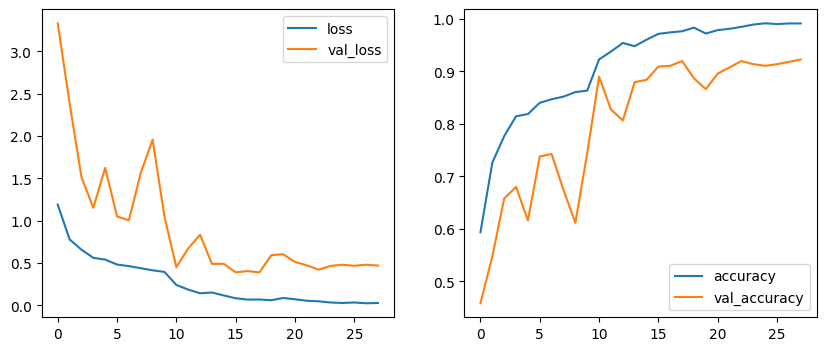

In [14]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [39]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 4s 6ms/step


In [40]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [41]:
labels = test_generator.labels

In [46]:
np.sum(labels != predictions)

65

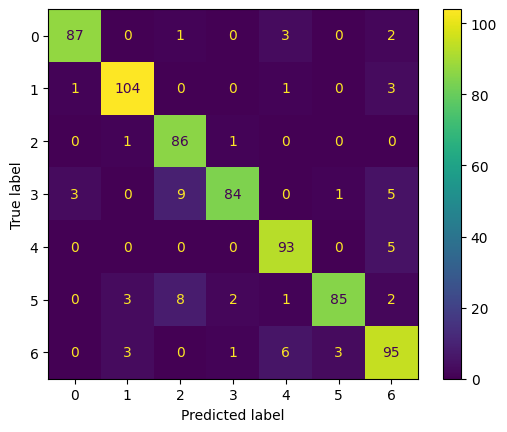

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [43]:
target_names = list(test_generator.class_indices.keys())

In [44]:
target_names

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [45]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.96      0.94      0.95        93
     compost       0.94      0.95      0.95       109
       glass       0.83      0.98      0.90        88
       metal       0.95      0.82      0.88       102
       paper       0.89      0.95      0.92        98
     plastic       0.96      0.84      0.89       101
       trash       0.85      0.88      0.86       108

    accuracy                           0.91       699
   macro avg       0.91      0.91      0.91       699
weighted avg       0.91      0.91      0.91       699



## Save model

Sau khi save xong hãy tải xuống và up lên drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [23]:
!mkdir pretrained_models

In [24]:
%cd pretrained_models

/content/drive/MyDrive/pretrained_models


In [25]:
model.save('MobileNet_retrain')

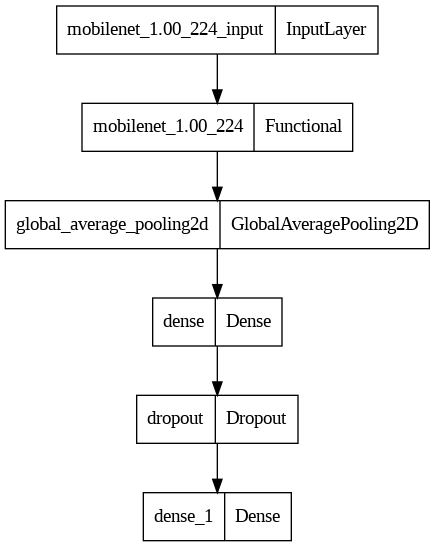

In [26]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

## Load model

https://drive.google.com/file/d/1vZG-eKSgnkpYG4W6IyE0KJcsC7hBQVgY/view?usp=drive_link

In [61]:
!gdown 1vZG-eKSgnkpYG4W6IyE0KJcsC7hBQVgY

Downloading...
From: https://drive.google.com/uc?id=1vZG-eKSgnkpYG4W6IyE0KJcsC7hBQVgY
To: /content/drive/MyDrive/pretrained_models/MobileNet_retrain.zip
100% 41.2M/41.2M [00:00<00:00, 136MB/s]


In [ ]:
!unzip MobileNet_retrain.zip

In [ ]:
import tensorflow as tf

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('MobileNet_retrain')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 24,587,271
Non-trainable params: 53,120
_____________________________________

## Error Analysis

In [54]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 7s 9ms/step


In [55]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [56]:
target_names = list(test_generator.class_indices.keys())

In [50]:
labels = test_generator.labels

In [57]:
import matplotlib.pyplot as plt


for i in range(0,699):
    x = test_generator.next()
    image = x[0]
    if (labels[i] != predictions[i]):
        plt.imshow(image)
        plt.title(f"Label: {target_names[labels[i]]}, pred: {target_names[predictions[i]]}")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [58]:
label_dict = dict(zip(range(7),target_names))
match_label = lambda x: label_dict[x]

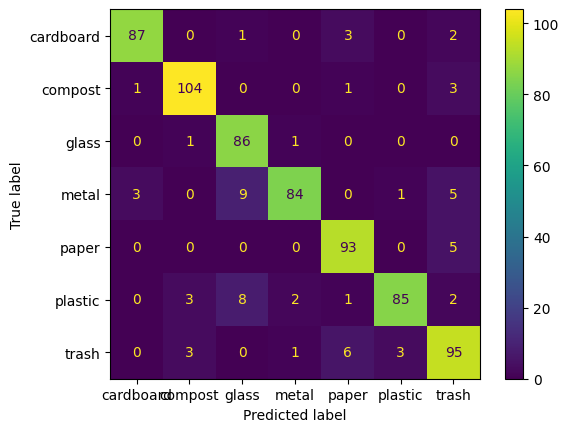

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(list(map(match_label, labels)), list(map(match_label, predictions)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show();